In [7]:
import pandas as pd
import os,re,codecs
import jieba,jieba.posseg as posseg,jieba.analyse as analyse
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import Birch,KMeans,OPTICS,DBSCAN,AgglomerativeClustering,AffinityPropagation
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
import matplotlib
import paddlehub as hub
import paddle.fluid as fluid 
from paddlehub.reader.tokenization import load_vocab
from gensim import corpora, models
import gensim
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import warnings
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
original_data = 'original-data-file'
generated_data='generated-data-file'

In [8]:
data1 = pd.read_excel(os.path.join(original_data,'车主说1.xlsx'))
data2 = pd.read_excel(os.path.join(original_data,'车主说2.xlsx'))
data3 = pd.read_excel(os.path.join(original_data,'车主说3.xlsx'))
with open(os.path.join(original_data,'contents.txt'), "r") as f:
    data4 = f.readlines()  # 读取文件

数据清洗和预处理

In [11]:
class Data():
    def __init__(self,data_all):
        data_clean=[]
        #数据清理
        for i in data_all:
            data_clean.append(self.data_clean(i))
        #数据拼接
        data_all_clean=data_clean[0]
        for i in range(1,len(data_clean)):
            data_all_clean=pd.concat([data_all_clean,data_clean[i]])
        data_all_clean=data_all_clean.reset_index(drop=True)#清洗后的中间产物
        self.data_sentence=data_all_clean[data_all_clean['content_type']=='sentence'].reset_index(drop=True)
        #数据预处理
        
        self.data_sentence=self.nlp_process(self.data_sentence)
        self.words_pos=self.nlp_pos()
        self.words_matrix=self.data_sentence['words'].values.tolist()
        self.words_cut=self.data_sentence['cut'].values.tolist()
        self.words_tfkey=self.data_sentence['tf_extract'].values.tolist()
    #按词性筛查
    def nlp_pos(self):
        with open(os.path.join(original_data,'hit_stopwords.txt'),"r") as fp:
            hit_stopwords = fp.read()
        pos_filter=['an','dg','g','j','Ng','n','nr','ns','nt','nz','vd','un']
        wpos=[]
        for i in self.data_sentence['pos']:
            temp=[]
            for w in i:
                if w.flag in pos_filter and w.word not in hit_stopwords:
                    temp.append(w.word)
            wpos.append(temp)
        return wpos
    def tri_judge(self,x):
        if x=='已删除' or x=='sys':
            return 2
        elif x=='已发布' or x=='ios':
            return 1
        else: return 0
    def word_pre_process(self,x):
        if type(x)==str:
            if 'Daker' in x:
                return 
            else:
                x_new = re.findall('[\u4e00-\u9fa5a-zA-Z0-9]+',x,re.S)
                x_new = "".join(x_new)
                x_new=x_new.upper()
                return x_new
        else:
            return x
    def content_pre_process(self,x):
        if '<!DOCTYPE html>'in x:
            return 'html'
        else:
            return 'sentence'
    def data_clean(self,data):
        not_process_colums=['member_id','like_num','read_num','comment_num','share_num','remark','release_time','is_member']
        data_new=data[not_process_colums]
        data_new['status']=data['status'].apply(lambda x:self.tri_judge(x))
        data_new['source']=data['source'].apply(lambda x:self.tri_judge(x))
        #三大件
        data_new['title']=data['title'].apply(lambda x:self.word_pre_process(x))
        data_new['introduction']=data['introduction'].apply(lambda x:self.word_pre_process(x))
        data_new['content']=data['content'].apply(lambda x:self.word_pre_process(x))
        data_new.drop(data_new[(data_new.content=='') | (data_new.content=='一')].index, inplace=True)
        data_new['content_type']=data['content'].apply(lambda x:self.content_pre_process(x))
        return data_new
    def delete_stopwords(self,x,hit_stopwords):
        return [w for w in x if w not in hit_stopwords]
    def nlp_process(self,data):
        data['cut']=data['content'].apply(lambda x:jieba.lcut(x,cut_all=False,HMM=True))
        #去停用词
        with open(os.path.join(original_data,'hit_stopwords.txt'),"r") as fp:
            hit_stopwords = fp.read()
        data['cut_stop']=data['cut'].apply(lambda x:self.delete_stopwords(x,hit_stopwords))
        #data_sentence.apply(lambda x:x['cut'].insert(0,str(x.name)),axis=1)
        data['words']=data['cut'].apply(lambda x:' '.join(x))
        #pos
        data['pos']=data['content'].apply(lambda x:posseg.cut(x))
        #基于tf-idf的关键词抽取
        data['tf_extract']=data['content'].apply(lambda x:analyse.extract_tags(x))
        #textrank的关键词抽取
        data['textrank_extract']=data['content'].apply(lambda x:analyse.textrank(x, topK=5))
        return data
        #去除看似没用的列
#         del data_sentence['member_id']
#         del data_sentence['remark']
#         del data_sentence['release_time']
#         del data_sentence['title']
#         del data_sentence['introduction']
#         del data_sentence['content_type']

data_all=[data1,data2,data3]
data_new=Data(data_all)
# data4_new=[]
# for i in data4:
#     x=re.findall('[\u4e00-\u9fa5a-zA-Z0-9+.]+',i,re.S)
#     data4_new.append(''.join(x))
# data_new=pd.concat([data1_new,data2_new])
# data_new=pd.concat([data_new,data3_new]).reset_index(drop=True)
# data_new.to_csv(os.path.join(generated_data,'data.csv'),index=0)
# data4_cut=[jieba.lcut(x,cut_all=False,HMM=True) for x in data4_new]
# data4_cut_stop=[delete_stopwords(x,hit_stopwords) for x in data4_cut]
# data4_words=[' '.join(x) for x in data4_cut]
# data4_tf_extract=[analyse.extract_tags(x, topK=5) for x in data4_new]
# data4_tf_textrank_extract=[analyse.textrank(x, topK=5) for x in data4_new]
with open(os.path.join(generated_data,'BTM_input.dat'),"a+") as f:
    for i in data_new.words_tfkey:
        s=' '.join(i)
        f.writelines(s)
        f.writelines("\n")

# STEP 1：利用W2V/BOW将文本向量化，然后用聚类算法聚类 

特征构建：可以基于词袋模型构造文本特征，比如向量空间模型的词频矩阵、Tf-Idf矩阵，又比如LSA和LDA，也可以用word2vec、glove等文本分布式表示方法，来构造文本特征，向量空间模型（Vector Space Model，VSM）也就是单词向量空间模型，区别于LSA、PLSA、LDA这些话题向量空间模型，但是单词向量空间模型和话题向量空间模型都属于词袋模型，又和word2vec等文本分布式表示方法相区别

In [83]:
#基于sklearn的tf-idf
vectorizer = CountVectorizer()
cntTf=vectorizer.fit_transform(data_new.words_matrix)
tf_feature_names = vectorizer.get_feature_names()
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(cntTf)
word= vectorizer.get_feature_names()
weight = tfidf.toarray()

降维部分

In [8]:
def pca_data(data,components):
    pca = PCA(components)
    X = pca.fit_transform(data)
    k=pca.n_components_
    print(k)
    pca_2 = PCA(n_components=k)
    return pca.fit_transform(data)

In [71]:
pca_d=pca_data(weight,0.99)

1955


评价函数

In [9]:
def metrics_cluster(x,y):
    #sample_silhouette_values = silhouette_samples(x, y) # 每个点的轮廓系数
    # DBI的值最小是0，值越小，代表聚类效果越好。
    #CH index的数值越大越好
    print('平均轮廓系数:',metrics.silhouette_score(x,y, metric='euclidean'))
    print('DBI系数:',metrics.davies_bouldin_score(x, y))
    print('CH系数:',metrics.calinski_harabasz_score(x, y))
    #return silhouette_avg,sample_silhouette_values,cluster_score_DBI,cluster_score_ch


分布式文本向量表征

In [124]:
#!hub install word2vec_skipgram==1.0.0
#加载paddle预训练模型
module = hub.Module(name="word2vec_skipgram")  # 实例化 word2vec_skipgram 模型
inputs, outputs, program = module.context(trainable=False)
#使用paddle的预训练模型
class Paddle_W2V_Tool(): 
    def __init__(self,word_data,weight,average):
        self.weight=weight#句向量的权重
        self.average=average#是否对句向量取平均操作
        self.word_data=word_data
        vocab = load_vocab(module.get_vocab_path())# 获得 词表 字典
        word_ids = inputs["word_ids"]
        embedding = outputs["word_embs"]
        place = fluid.CPUPlace()  # 设备描述符，表示 CPU 设备
        exe = fluid.Executor(place)  # 将执行器的类 进行实例化
        feeder = fluid.DataFeeder(feed_list=[word_ids], place=place)
        self.vector=self.sentence_embedding(vocab,exe,program,feeder,embedding)
    def sentence_embedding(self,vocab,exe,program,feeder,embedding):
        sentence_vec=[]
        #不含权重的表示句向量
        if self.weight==0 or type(self.weight)!=list:
            for item in self.word_data:
                text = self.convert_tokens_to_ids(vocab, item)  # 获得组成句子的 词语 的 ID 列表
                exe.run(fluid.default_startup_program())
                vecs, =exe.run(program,feed=feeder.feed([[text]]),fetch_list=[embedding.name],return_numpy=False)
                vecs = np.array(vecs)
                sent_emb = np.sum(vecs, axis=0)  #求和
                if self.average==1:  
                    sentence_vec.append(sent_emb/len(text))
                else:
                    sentence_vec.append(sent_emb)
        else:#含权重的表示句向量
            try:
                for item in range(len(self.word_data)):
                    text = self.convert_tokens_to_ids(vocab, self.word_data[item])  # 获得组成句子的 词语 的 ID 列表
                    exe.run(fluid.default_startup_program())
                    vecs, =exe.run(program,feed=feeder.feed([[text]]),fetch_list=[embedding.name],return_numpy=False)
                    vecs = np.array(vecs)
                    vecs=[ x*y for x in self.weight[item] for y in vecs]#加权
                    sent_emb = np.sum(vecs, axis=0)#求和
                    sentence_vec.append(sent_emb)
                    if self.average==1:      
                        sentence_vec.append(sent_emb/len(text))
                    else:
                        sentence_vec.append(sent_emb)
            except:print('please check the weight matrix')
        return sentence_vec
    # 这是把中文词语转化为词表中对应 ID 的函数
    def convert_tokens_to_ids(self,vocab, text):  # 输入为词表，和要转化的 text
        wids = []
        tokens = text.split(" ")
        for token in tokens:
            wid = vocab.get(token, None)
            if not wid:
                wid = vocab["unknown"]
            wids.append(wid)
        return wids
word_vec=Paddle_W2V_Tool(data_new.words_matrix,0,0).vector

[2020-09-07 17:21:46,446] [    INFO] - Installing word2vec_skipgram module
[2020-09-07 17:21:46,450] [    INFO] - Module word2vec_skipgram already installed in /home/jovyan/.paddlehub/modules/word2vec_skipgram
[2020-09-07 17:21:46,784] [    INFO] - 1 pretrained paramaters loaded by PaddleHub


自己训练

In [125]:
model_w2v = gensim.models.Word2Vec(data_new.words_matrix,size=250,window=5,min_count=1)
embedding = []
for idx, line in enumerate(data_new.words_matrix):
    vector = np.zeros(250)  
    for word in line:
        if word not in model_w2v.wv.vocab:
            vector += np.zeros(250)
        else:
            vector += model_w2v[word]
    embedding.append(vector)

2020-09-08 14:13:24,043-WARNING: consider setting layer size to a multiple of 4 for greater performance
2020-09-08 14:13:24,045-INFO: collecting all words and their counts
2020-09-08 14:13:24,045-WARNING: Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2020-09-08 14:13:24,046-INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-08 14:13:24,082-INFO: collected 2194 word types from a corpus of 232795 raw words and 2393 sentences
2020-09-08 14:13:24,082-INFO: Loading a fresh vocabulary
2020-09-08 14:13:24,088-INFO: effective_min_count=1 retains 2194 unique words (100% of original 2194, drops 0)
2020-09-08 14:13:24,088-INFO: effective_min_count=1 leaves 232795 word corpus (100% of original 232795, drops 0)
2020-09-08 14:13:24,095-INFO: deleting the raw counts dictionary of 2194 items
2020-09-08 14:13:24,096-INFO: sample=0.001 downsamples 50 most-common words
2020-09-08 14:13:24,096-INFO: d

In [126]:
X=embedding

可视化句向量

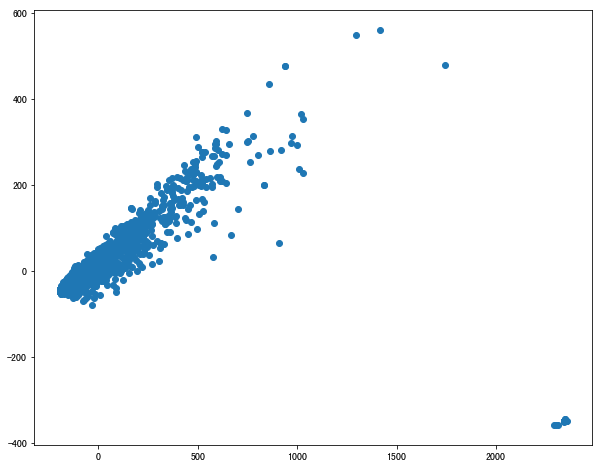

In [127]:
plt.figure(figsize=(10,8))
result = PCA(n_components=2).fit_transform(X)
# 可视化展示
plt.scatter(result[:, 0], result[:, 1])
# X = list(X)
# for i, x in enumerate(X):
#     x_c=result[i, 0]
#     y_c=result[i, 1]
#     plt.annotate(i, xy=(x_c,y_c ))
plt.show()

In [74]:
def result_to_file(num_cluster,y,data,name_method):
    cluster_df = pd.Series(y)
    for i in range(num_cluster):
        type_cluster = cluster_df[cluster_df.values == i]
        data_cluster=data.iloc[type_cluster.index,7]
        name=name_method+'cluster_'+str(i)+'.csv'
        data_cluster.to_csv(os.path.join(generated_data,name))

聚类算法部分，其他效果不好的算法去除了

kmeans

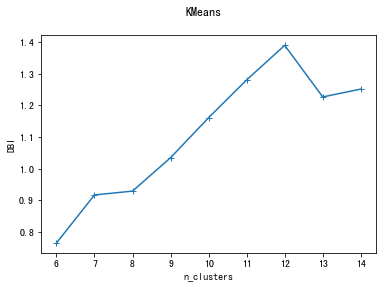

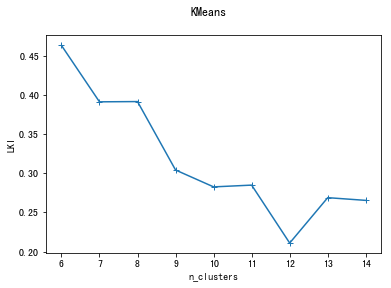

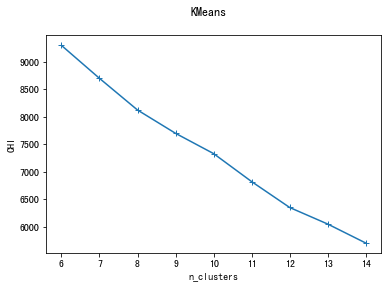

In [128]:
def test_KM_model(data):
    #类簇个数的影响
    nums=range(6,15)
    DBIs=[]
    LKs=[]
    CHs=[]
    for num in nums:
        clst=KMeans(n_clusters=num)
        predicted_labels=clst.fit_predict(data)
        DBIs.append(metrics.davies_bouldin_score(data, predicted_labels))
        LKs.append(metrics.silhouette_score(data, predicted_labels, metric='euclidean'))
        CHs.append(metrics.calinski_harabasz_score(data, predicted_labels))

    ## DBIs
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.plot(nums,DBIs,marker="+")
    ax.set_xlabel("n_clusters")
    ax.set_ylabel("DBI")
    fig.suptitle("KMeans")
    plt.show()
    ## LKs
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.plot(nums,LKs,marker="+")
    ax.set_xlabel("n_clusters")
    ax.set_ylabel("LKI")
    fig.suptitle("KMeans")
    plt.show()
    ## CHs
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.plot(nums,CHs,marker="+")
    ax.set_xlabel("n_clusters")
    ax.set_ylabel("CHI")
    fig.suptitle("KMeans")
    plt.show()
test_KM_model(X) 


In [129]:
km = KMeans(n_clusters=6, init='k-means++')
y1=km.fit(X)
cluster_df = pd.Series(y1.labels_)
metrics_cluster(X,y1.labels_)
for i in range(10):
    type_cluster = cluster_df[cluster_df.values == i]
    print('第'+str(i)+'类：',len(type_cluster))

平均轮廓系数: 0.46277232520364403
DBI系数: 0.7652851707583141
CH系数: 9299.019244796807
第0类： 1442
第1类： 37
第2类： 135
第3类： 24
第4类： 270
第5类： 485
第6类： 0
第7类： 0
第8类： 0
第9类： 0


AC层次聚类

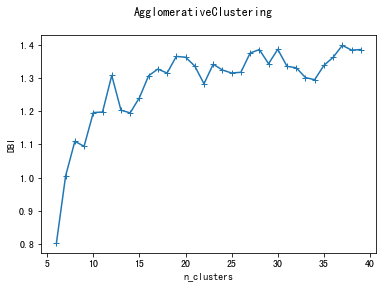

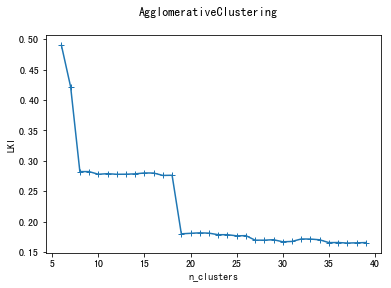

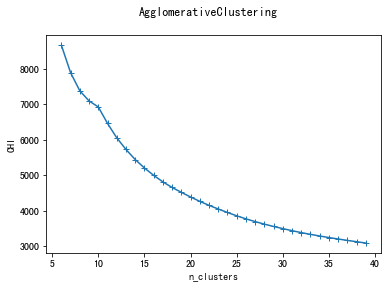

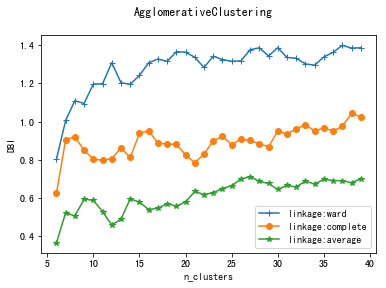

In [130]:

def AgglomerativeClustering_nclusters(data):
    #类簇个数的影响
    nums=range(6,40)
    DBIs=[]
    LKs=[]
    CHs=[]
    for num in nums:
        clst=AgglomerativeClustering(n_clusters=num)
        predicted_labels=clst.fit_predict(data)
        DBIs.append(metrics.davies_bouldin_score(data, predicted_labels))
        LKs.append(metrics.silhouette_score(data, predicted_labels, metric='euclidean'))
        CHs.append(metrics.calinski_harabasz_score(data, predicted_labels))

    ## DBIs
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.plot(nums,DBIs,marker="+")
    ax.set_xlabel("n_clusters")
    ax.set_ylabel("DBI")
    fig.suptitle("AgglomerativeClustering")
    plt.show()
    ## LKs
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.plot(nums,LKs,marker="+")
    ax.set_xlabel("n_clusters")
    ax.set_ylabel("LKI")
    fig.suptitle("AgglomerativeClustering")
    plt.show()
    ## CHs
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.plot(nums,CHs,marker="+")
    ax.set_xlabel("n_clusters")
    ax.set_ylabel("CHI")
    fig.suptitle("AgglomerativeClustering")
    plt.show()


def AgglomerativeClustering_linkage(data):
    nums=range(6,40)
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    # 链接方式的影响
    linkages=['ward','complete','average']
    markers="+o*"
    for i, linkage in enumerate(linkages):
        DBIs=[]
        for num in nums:
            clst=AgglomerativeClustering(n_clusters=num,linkage=linkage)
            predicted_labels=clst.fit_predict(data)
            DBIs.append(metrics.davies_bouldin_score(data, predicted_labels))
        ax.plot(nums,DBIs,marker=markers[i],label="linkage:%s"%linkage)

    ax.set_xlabel("n_clusters")
    ax.set_ylabel("DBI")
    ax.legend(loc="best")
    fig.suptitle("AgglomerativeClustering")
    plt.show()
AgglomerativeClustering_nclusters(X) 
AgglomerativeClustering_linkage(X) 

In [85]:
ac = AgglomerativeClustering(linkage='average',n_clusters = 6)
y4=ac.fit(X)
cluster_df = pd.Series(y4.labels_)
metrics_cluster(X,y4.labels_)
for i in range(11):
    type_cluster = cluster_df[cluster_df.values == i]
    temp=data_sentence.iloc[type_cluster.index,7]
    print('第'+str(i)+'类：',len(type_cluster))
    print(temp)
result_to_file(11,y1.labels_,data_sentence,'AC_')

平均轮廓系数: 0.7399989835481969
DBI系数: 0.3940576120742562
CH系数: 1378.5435741612225
第0类： 21
122     前两天刚去给车子做了保养开了这么久宝沃bx5风采依旧这次保养除了机油机滤外把空调滤芯也换了宝...
143     虽然是每天待在家里但是在家的日子还是挺充实的每天打扫卫生研究吃的陪孩子学习偶尔还抽空来洗洗车...
227     车内功能按键都怎么用肯定有很多小伙伴们对好多按键都不知道怎么用的空调大家都会用就是一些陌生的...
380     提车一年多了不管网上怎么说宝沃bx5的好与坏我或多或少都有了自己的认知有些确实如大家所见有些...
381     提车一年多了不管网上怎么说宝沃bx5的好与坏我或多或少都有了自己的认知有些确实如大家所见有些...
391     宝沃bx3是我朋友推荐的他对车比较关注平时出来什么新款车问他他比较懂一研究就懂然后我就去网上...
489     来说说我的半年多用车小结把遥想当初选车的时候真的是各种对比各种纠结在网上看测评对比配置最后成...
736     研究了一下宝沃BX3车机互联功能还挺好用设计的挺方便尤其是苹果手机可以直接通过Carplay...
886     厂家新版APP设计砖用及车辆联网的所谓工程师请新版APP正时使用前不要对车机系统进行升级如春...
983     一人一车一世界有了宝沃bx5之后我也能潇洒出门了入手宝沃bx5已经小半年的时间了宝沃bx5的...
1139    寻寻觅觅这么久我终于拥有了人生中的第一辆车2020宝沃bx5先锋款激动之心难以言表预算有限想...
1410    宝沃BX5开3年了经常小问题不断大问题常有几乎去4S店的时间比正常开的时间还要多2019年2...
1488    有宝沃bx3在身边真的是无比踏实想去哪都不用担心有没有车赶不赶得上车等等真是庆幸自己之前没犹...
1600    各位车友注意了前方高能预警我买的是2016款四驱豪华版至今七万多公里油耗平均市区为12135...
1660    第一批车主四年了很客观的来说一说包括第一批车友的评价第一车子动力那是没话说很满意的至于油耗真...
1845    还不到三个月的时间宝沃bx5已经跑了五千公里了有车之后我发现自己都改变了

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys


# STEP 2：主题模型LDA-软聚类
### LDA不是万能的，数据质量好，lda就有效，反之就无效,LDA模型的使用场景及需要注意的问题：
     主题模型需要大量的文本数据；
     适合长文本，比如文章的正文数据，不适合微博、评论这样的短文本数据; 基于用户做聚合可以一定程度上提升效果
     小语料库意味着LDA算法可能不会为每个单词分配较为理想的主题比例；
     微调模型的参数并收集更多的语料库将提升模型表现，最终改善词汇着色的结果。 

In [12]:
data=data_new.words_pos#LDA的输入试过原句，去停用词句，按照tf提取关键词句
# with open(os.path.join(original_data,'not_topic.txt'),"r") as fp:
#     not_topic = fp.read()

测试

In [13]:
dictionary = corpora.Dictionary(data)
#过滤文档频率大于no_below，小于no_above*num_docs的词
dictionary.filter_extremes(no_below=0.7, no_above=0.1)
items = dictionary.iteritems()
bad_ids = []
for item in items:
    if len(item[1])<=1:
        bad_ids.append(item[0])
dictionary.filter_tokens(bad_ids = bad_ids)
# 生成稀疏向量集
corpus = [dictionary.doc2bow(words) for words in data]
# tfidf = models.TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]
#mallet一直报错
#lda = gensim.models.wrappers.LdaMallet('original-data-file/new_mallet/mallet-2.0.8/bin/mallet',corpus,num_topics=10,id2word=dictionary)
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=8,chunksize=100,iterations=50)
for topic in lda.print_topics():
    print(topic)
#评价指标一：困惑度，大家说：这个指标不太靠谱，而且gensim自带的log_perplexity方法没有做归一化不能相互比较，越小越好
print('困惑度：',lda.log_perplexity(corpus))
#评价指标二：主题一致性，越大越好
coherence_model_lda = models.CoherenceModel(model=lda, texts=data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

(0, '0.169*"4S店" + 0.071*"工作人员" + 0.057*"厂家" + 0.051*"汽车" + 0.046*"质保" + 0.039*"远程" + 0.032*"标准" + 0.017*"衡阳" + 0.014*"郴州" + 0.014*"客服"')
(1, '0.073*"功能" + 0.043*"大家" + 0.042*"手机" + 0.033*"钥匙" + 0.026*"毛病" + 0.026*"刹车" + 0.025*"原因" + 0.022*"公司" + 0.019*"轿车" + 0.019*"方向盘"')
(2, '0.098*"油耗" + 0.045*"感觉" + 0.044*"动力" + 0.033*"时间" + 0.033*"版本" + 0.027*"新车" + 0.025*"系统" + 0.019*"市区" + 0.018*"底盘" + 0.018*"座椅"')
(3, '0.057*"车友" + 0.032*"胎压" + 0.031*"客服" + 0.027*"车门" + 0.027*"大灯" + 0.027*"车载" + 0.024*"垃圾" + 0.024*"行车" + 0.023*"电话" + 0.022*"意思"')
(4, '0.068*"车主" + 0.060*"车辆" + 0.055*"售后" + 0.033*"故障" + 0.032*"声音" + 0.030*"轮胎" + 0.020*"车友们" + 0.020*"功能" + 0.017*"变速箱" + 0.017*"电瓶"')
(5, '0.148*"机油" + 0.114*"发动机" + 0.043*"朋友" + 0.039*"空调" + 0.026*"电池" + 0.023*"质量" + 0.021*"品牌" + 0.016*"大家" + 0.015*"车子" + 0.014*"老铁"')
(6, '0.082*"车子" + 0.046*"配件" + 0.028*"模式" + 0.028*"定位" + 0.027*"仪表盘" + 0.025*"天窗" + 0.019*"记录仪" + 0.017*"问问" + 0.014*"联网" + 0.012*"爱车"')
(7, '0.053*"空间" + 0.048*"买车" + 0.042*"安全" + 0.

LDA训练

In [14]:
import logging
logging.getLogger().setLevel(logging.ERROR)

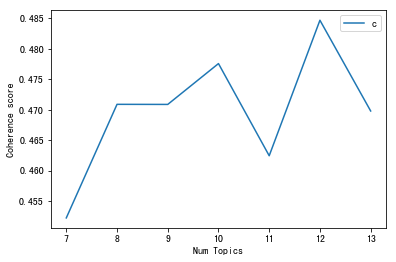

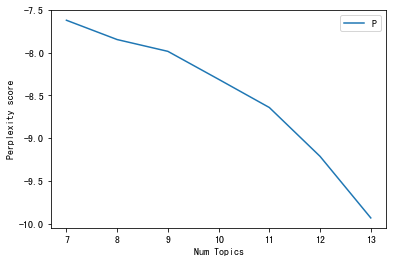

In [15]:
# data=data+data4_cut_stop
def LDA_train(data,min_num_topics,max_num_topics):
    perplexity_values = []
    coherence_values=[]
    model_list = []
    # 生成语料词典
    dictionary = corpora.Dictionary(data)
    #过滤文档频率大于no_below，小于no_above*num_docs的词
    dictionary.filter_extremes(no_below=0.7, no_above=0.1)
    items = dictionary.iteritems()
    bad_ids = []
    for item in items:
        if len(item[1])<=1:
            bad_ids.append(item[0])
    dictionary.filter_tokens(bad_ids = bad_ids)
    # 生成稀疏向量集
    corpus = [dictionary.doc2bow(words) for words in data]
    for topic_num in range(min_num_topics,max_num_topics+1):
        lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=topic_num,chunksize=100,iterations=50)
        model_list.append(lda)
#         for topic in lda.print_topics():
#             print(topic)
        #评价指标一：困惑度，大家说：这个指标不太靠谱，而且gensim自带的log_perplexity方法没有做归一化不能相互比较，越小越好
        #print('困惑度：',lda.log_perplexity(corpus))
        perplexity_values.append(lda.log_perplexity(corpus))
        #评价指标二：语义连贯值，越大越好
        coherence_model_lda = models.CoherenceModel(model=lda, texts=data, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())
    return model_list, coherence_values,perplexity_values,dictionary
model_list, coherence_values,perplexity_values,dictionary_best=LDA_train(data,7,13)
loction=coherence_values.index(max(coherence_values))
best_lda=model_list[loction]
limit=14; start=7; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("Perplexity_values"), loc='best')
plt.show()

LDA结果处理和展示

In [16]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    # 在每个文档中获取主要的主题
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # 提出每篇文档主要主题，贡献值，关键词
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['主题类型', '贡献率', '主题关键词']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=best_lda, corpus=corpus, texts=data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['编号', '主题类型', '贡献率', '主题关键词', '文档内容']
df_dominant_topic

,编号,主题类型,贡献率,主题关键词,文档内容
0,0,8.0,0.5452,"机油, 手机, 空调, 地方, 电池, 质量, 电瓶, 神州, 意思, 老铁","[神州, 祝福, 奖]"
1,1,0.0,0.0833,"发动机, 车主, 声音, 远程, 版本, 功能, 车门, 车载, 品牌, 车窗",[]
2,2,0.0,0.0833,"发动机, 车主, 声音, 远程, 版本, 功能, 车门, 车载, 品牌, 车窗",[]
3,3,9.0,0.8189,"油耗, 动力, 新车, 轿车, 底盘, 市区, 用车, 基本, 中控, 一键","[颜值, 双色, 车身, 动力, 动控, 高性能, 宝沃, 沃, 潮流]"
4,4,3.0,0.0833,"先锋, 效果, 新手, 指导, 油表, 大哥, 开宝, 操控性, 项目, 刹车片","[宝, 沃沃]"
5,5,0.0,0.0833,"发动机, 车主, 声音, 远程, 版本, 功能, 车门, 车载, 品牌, 车窗","[宝沃, 车]"
6,6,9.0,0.5417,"油耗, 动力, 新车, 轿车, 底盘, 市区, 用车, 基本, 中控, 一键",[油耗]
7,7,0.0,0.0833,"发动机, 车主, 声音, 远程, 版本, 功能, 车门, 车载, 品牌, 车窗",[]
8,8,0.0,0.0833,"发动机, 车主, 声音, 远程, 版本, 功能, 车门, 车载, 品牌, 车窗",[]
9,9,3.0,0.0833,"先锋, 效果, 新手, 指导, 油表, 大哥, 开宝, 操控性, 项目, 刹车片",[玩意]


In [17]:
sent_topics_sorted = pd.DataFrame()
sent_topics_out = df_dominant_topic.groupby('主题类型')
for i, group in sent_topics_out:
    sent_topics_sorted = pd.concat([sent_topics_sorted, group.sort_values(['贡献率'], ascending=[0]).head(1)],axis=0)
sent_topics_sorted.reset_index(drop=True, inplace=True)
sent_topics_sorted.columns = ['索引号','主题类型', '主题贡献率', "主题关键词", "文档内容示例"]
sent_topics_sorted

,索引号,主题类型,主题贡献率,主题关键词,文档内容示例
0,1942,0.0,0.8818,"发动机, 车主, 声音, 远程, 版本, 功能, 车门, 车载, 品牌, 车窗","[宝沃, 车, 新手机, 信息, 车门, 版本, 版本, 版本, 版本号, 版本号]"
1,843,1.0,0.8324,"车子, 大家, 时间, 毛病, 公司, 涡轮, 悬架, 速度, 天气, 温度","[温度, 车子, 温度, 产生, 气体]"
2,601,2.0,0.8167,"厂家, 质保, 故障, 朋友, 客服, 定位, 垃圾, 电话, 无法, 指点","[定位, 新款, 定位, 离谱, 车]"
3,1040,3.0,0.8526,"先锋, 效果, 新手, 指导, 油表, 大哥, 开宝, 操控性, 项目, 刹车片","[新手, 版, 先锋, 中配, 雷达, 雷达, 雷达]"
4,106,4.0,0.7785,"4S店, 工作人员, 买车, 空间, 体验, 问问, 车子, 异响, 缺点, 动力","[公司, 办公, 买车, 4S店, 宝沃, 态度, 体验, 小时, 网点, 全国, 网点, ..."
5,411,5.0,0.8479,"功能, 车辆, 汽车, 钥匙, 后备箱, 刹车, 家用, 样子, 蓝牙, 大家","[上线, 蓝牙, 钥匙, 老款, 功能, 模块]"
6,345,6.0,0.8494,"售后, 车友, 轮胎, 胎压, 车友们, 模式, 仪表盘, 师傅, 价格, 性能","[轮胎, 糗, 轮胎, 胎压, 师傅, 下胎, 压, 普及, 胎压, 爆胎, 现象, 花纹,..."
7,2235,7.0,0.8666,"东西, 玻璃, 爱车, 保险, 媳妇, 后视镜, 细节, 黑色, 评价, 造型","[挡泥板, 车费, 纸皮, 毛毯, 塑料, 壳, 耗油]"
8,400,8.0,0.8854,"机油, 手机, 空调, 地方, 电池, 质量, 电瓶, 神州, 意思, 老铁","[机油, 滤芯, 火花塞, 替代, 型号, 原厂, 机油, 滤芯, 牌, 代工, 孔]"
9,1380,9.0,0.8726,"油耗, 动力, 新车, 轿车, 底盘, 市区, 用车, 基本, 中控, 一键","[车子, 显示屏, 电源, 门, 显示屏, 断电, 通电, 门锁, 锁门]"


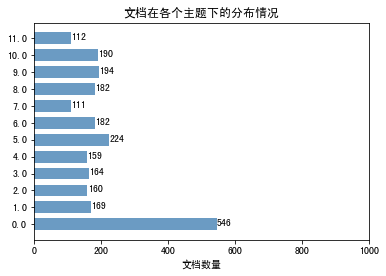

,主题类型,主题关键词,文档数量,文档百分比
0,0.0,"发动机, 车主, 声音, 远程, 版本, 功能, 车门, 车载, 品牌, 车窗",546,0.2282
1,1.0,"车子, 大家, 时间, 毛病, 公司, 涡轮, 悬架, 速度, 天气, 温度",169,0.0706
2,2.0,"厂家, 质保, 故障, 朋友, 客服, 定位, 垃圾, 电话, 无法, 指点",160,0.0669
3,3.0,"先锋, 效果, 新手, 指导, 油表, 大哥, 开宝, 操控性, 项目, 刹车片",164,0.0685
4,4.0,"4S店, 工作人员, 买车, 空间, 体验, 问问, 车子, 异响, 缺点, 动力",159,0.0664
5,5.0,"功能, 车辆, 汽车, 钥匙, 后备箱, 刹车, 家用, 样子, 蓝牙, 大家",224,0.0936
6,6.0,"售后, 车友, 轮胎, 胎压, 车友们, 模式, 仪表盘, 师傅, 价格, 性能",182,0.0761
7,7.0,"东西, 玻璃, 爱车, 保险, 媳妇, 后视镜, 细节, 黑色, 评价, 造型",111,0.0464
8,8.0,"机油, 手机, 空调, 地方, 电池, 质量, 电瓶, 神州, 意思, 老铁",182,0.0761
9,9.0,"油耗, 动力, 新车, 轿车, 底盘, 市区, 用车, 基本, 中控, 一键",194,0.0811


In [18]:
topic_counts = df_dominant_topic['主题类型'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = sent_topics_sorted[['主题类型', '主题关键词']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['主题类型', '主题关键词', '文档数量', '文档百分比']
plt.barh(range(len(sent_topics_sorted['主题类型'])), np.array(df_dominant_topics['文档数量']), height=0.7, color='steelblue', alpha=0.8)
plt.yticks(range(len(sent_topics_sorted['主题类型'])), sent_topics_sorted['主题类型'])
plt.xlim(1,1000)
plt.xlabel("文档数量")
plt.title("文档在各个主题下的分布情况")
for x, y in enumerate(df_dominant_topics['文档数量']):
    plt.text(y + 0.2, x - 0.1, '%s' % y)
plt.show()
df_dominant_topics

In [19]:
best_lda.save(os.path.join(generated_data,'LDA.model'))

In [16]:
lda_model_new = models.LdaModel.load(os.path.join(generated_data,'LDA.model'))

# STEP 3：其他主题模型（更适合短文本的主题模型例如：BTM，twitterlda）

# BTM:a biterm topic model for short texts

In [14]:
#Author: 一蓑烟雨任平生
import BTM
import time
import sys
import math 
from BTM.src import indexDocs,Model,topicDisplay
from BTM.src.Model import Doc
mode = "est"
K =9
W = None
alpha = 0.1
beta = 0.3
n_iter = 3 #十次迭代
save_step = 100 
dir = "generated-data-file/btm_output/"
input_dir = "original-data-file/btm_data/"
model_dir = dir + "model/" #模型存放的文件夹
voca_pt = dir + "voca.txt" #生成的词典
dwid_pt = dir + "doc_wids.txt" #每篇文档由对应的序号单词组成
doc_pt = input_dir + "BTM_input.dat" #输入的文档

# W生成的词典
W = indexDocs.run_indexDocs(['indexDocs',doc_pt,dwid_pt,voca_pt]) #返回的是词典中一共有2700个单词

print("W : "+str(W))
def usage() :
    print("Training Usage: \
    btm est <K> <W> <alpha> <beta> <n_iter> <save_step> <docs_pt> <model_dir>\n\
    \tK  int, number of topics, like 20\n \
    \tW  int, size of vocabulary\n \
    \talpha   double, Pymmetric Dirichlet prior of P(z), like 1.0\n \
    \tbeta    double, Pymmetric Dirichlet prior of P(w|z), like 0.01\n \
    \tn_iter  int, number of iterations of Gibbs sampling\n \
    \tsave_step   int, steps to save the results\n \
    \tdocs_pt     string, path of training docs\n \
    \tmodel_dir   string, output directory")

def BTM(argvs):
    if(len(argvs)<4):
        usage()
    else:
        if (argvs[0] == "est"):
            K = argvs[1]
            W = argvs[2]
            alpha = argvs[3]
            beta = argvs[4]
            n_iter = argvs[5]
            save_step = argvs[6]
            docs_pt = argvs[7]
            dir = argvs[8]
            model = Model.BTM_Model(K, W, alpha, beta, n_iter, save_step)
            model.run(docs_pt,dir)
            return model
        else:
            usage()
            
argvs = []
argvs.append(mode)
argvs.append(K)
argvs.append(W)
argvs.append(alpha)
argvs.append(beta)
argvs.append(n_iter)
argvs.append(save_step)
argvs.append(dwid_pt)
argvs.append(model_dir)
print("=============== Topic Learning =============")
lda_model=BTM(argvs)
print(lda_model)


index file: original-data-file/btm_data/BTM_input.dat
write file: generated-data-file/btm_output/doc_wids.txt
n(w)=9317
write:generated-data-file/btm_output/voca.txt
W : 9317
=============== Topic Learning =============
load docs: generated-data-file/btm_output/doc_wids.txt
Begin iteration

write p(z): generated-data-file/btm_output/model/k9.pz
write p(w|z): generated-data-file/btm_output/model/k9.pw_z


In [30]:
print("================ Topic Display =============")
mode = "est"
K = 5
dir = "generated-data-file/btm_output/"
input_dir = "original-data-file/btm_data/"
model_dir = dir + "model/" #模型存放的文件夹
voca_pt = dir + "voca.txt" #生成的词典
dwid_pt = dir + "doc_wids.txt" #每篇文档由对应的序号单词组成
doc_pt = input_dir + "trndocs.dat" #输入的文档
argvs = []
argvs.append(mode)
argvs.append(model_dir)
argvs.append(K)
argvs.append(voca_pt)
argvs.append(dwid_pt)
topicDisplay.perplexity(argvs)
topicDisplay.load_docs(dwid_pt)
topicDisplay.run_topicDicplay(argvs)

================ Topic Display =============


NameError: name 'topicDisplay' is not defined

# STEP 4：LDA和W2V/D2V结合，用主题模型推导出主题，再结合W2V/D2V将主题和文档向量化，利用相似度来聚类

9.2日：w2v+lda的思路无法进行，w2v表达出来的句向量很不好；得到LDA优化思路之一：使用mallet包的LDA通常比gensim的LDA效果更好(貌似需要jdk环境，没有调试成功，先记下这个事)，优化思路之二是使用TF-IDF训练LDA模型，这个在北航项目中也看到了相关代码，但是他们注释掉了，是不是因为没啥效果？

In [104]:
topic_words=[]#主题词
topic_word_weight =[]#每个主题词的占权重
#计算主题词的权重
size_lda_topic=loction+5
for x in range(size_lda_topic):
    topic_words.append(" ".join([word for word, prop in best_lda.show_topic(x)]))
    the_sum=sum([xx[1] for xx in best_lda.get_topic_terms(x)])
    topic_word_weight.append([xx[1]/the_sum for xx in best_lda.get_topic_terms(x)])
#将主题映射到向量空间
topic_vector=np.zeros([size_lda_topic,128])
#主题下每个词在word2vec下表示加权求和
topic_vector=Paddle_W2V_Tool(topic_words,topic_word_weight,0).vector
#映射文档到word2vec
doc_vector=Paddle_W2V_Tool(words_matrix,0,0).vector
# #计算训练集文档与个主题间距
def Euclidean_distance(a,b):#欧氏距离距离
    return np.sqrt(np.sum(np.square(a-b)))
#计算文档与主题相似性
def distance_vector(vector1,vector2):
    doc_topic_distance=np.zeros([len(vector1),len(vector2)])
    for i in range(len(words_matrix)):
        for j in range(size_lda_topic):
            doc_topic_distance[i][j]=Euclidean_distance(vector1[i],vector2[j])
    return doc_topic_distance
doc_topic_dis=distance_vector(doc_vector,topic_vector)

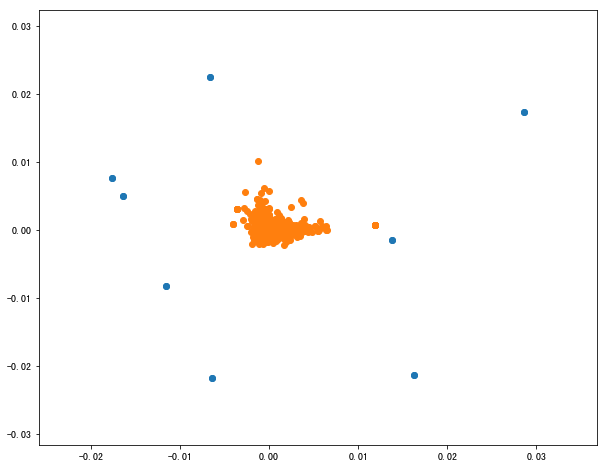

In [112]:
plt.figure(figsize=(10,8))
topic = PCA(n_components=2).fit_transform(topic_vector)
doc=PCA(n_components=2).fit_transform(doc_vector)
#doc_t_dis=PCA(n_components=2).fit_transform(doc_topic_dis)
# 可视化展示
plt.scatter(topic[:, 0], topic[:, 1])
plt.scatter(doc[:, 0], doc[:, 1])
#plt.scatter(doc_t_dis[:, 0], doc_t_dis[:, 1])
X = list(X)
plt.show()
#蓝点为主题向量，黄点为文档向量，一脸蒙蔽